# Behavioural performance

For the statistical analyses of the behavioural data we used R (v3.5.2, 2018-12-20) in RStudio (v1.1.463, RStudio, Inc, Boston, MA). The data and detailed analysis notebook are freely available at …   The significance threshold for all statistical comparisons was p < 0.05. Univariate and bi-variate outliers were identified using box plot method, which relies on the interquartile range.

## Analysis prerequisites

In [1]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.0                         
year           2019                        
month          04                          
day            26                          
svn rev        76424                       
language       R                           
version.string R version 3.6.0 (2019-04-26)
nickname       Planting of a Tree          

### Libraries and functions

In [16]:
# Dace Apšvalka @MRC CBU, 2019
# ----------------------------------------------------------------------
# LIBRARIES
# ----------------------------------------------------------------------
library(Hmisc, warn.conflicts = FALSE) 
library(plyr)      # for ddply (aggregating SST results)
library(pastecs)   # for summary statistic
library(ggplot2)   # for plotting results
library(repr)      # for changing plot size (default too large in notebook)
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(aplpack)   # for bi-variate outlier, bgplot
library(robust)    # for robust correlation

# ----------------------------------------------------------------------
# FUNCTIONS
# ----------------------------------------------------------------------

# 1. STOP-SIGNAL ANALYSIS
# Based on: Verbruggen et al (2019). https://doi.org/10.7554/eLife.46323.001
# ------------------------------------
funcSignal <- function(data) {
  # all trials with a Response (any)
  data$resp <- ifelse(data$gRT == "0", 0, 1)
  
  # Stop-signal trials
  # ----------------------------------------------------------------------
  # All
  signal <- subset(data, gkind == '1')
  # probability of responding to the Stop-Signal
  presp <-  mean(signal$resp)
  # mean Stop-Signal Delay (of all Stop-Signal trials)
  ssd <- mean(signal$gintVal)
  # unsuccessful Stop RTs
  signal.resp    <- subset(signal, resp == '1')
  signal.resp.rt <- mean(signal.resp$gRT)
  
  # Go trials
  # ----------------------------------------------------------------------
  # All
  nosignal <- subset(data, gkind == '0') 
  # With response
  nosignal_resp <- subset(nosignal, resp == '1') 
  # probability of Go omossions
  pmiss <- 1-mean(nosignal$resp)
  # Correct Go trials
  nosignal_resp$error <-
    ifelse(nosignal_resp$gtheButton == nosignal_resp$gresp, 0, 1)
  # Probability of Go choice errors
  perror <- mean(nosignal_resp$error)
  # for the missed responses, set RT to max RT of the subject
  nosignal$gRT <-
    ifelse(nosignal$gRT == 0, max(nosignal_resp$gRT), nosignal$gRT)
  # RT for Go trials with a response
  nosignal.resp.rt <- mean(nosignal_resp$gRT)
  # RT for correct Go trials
  nosignal.correctresp <- subset(nosignal_resp, error == '0')
  nosignal.correctresp.rt <- mean(nosignal.correctresp$gRT)
  
  # SSRT
  # ----------------------------------------------------------------------
  # All Go trials are included when the nth RT is determined
  ## determine nth RT
  nthRT_all <- quantile(nosignal$gRT, probs = presp, type = 6)
  ## SSRT(integration) = nthRT - ssd
  SSRTall <- nthRT_all - ssd
  
  # Race Check
  # ----------------------------------------------------------------------
  # All Go trials
    # "..this comparison should include all trials with a response (including choice errors and premature responses).." 
    # (Verbruggen et al., 2019))
  race.check <- nosignal.resp.rt - signal.resp.rt
  
  # Output
  # ----------------------------------------------------------------------
  return(
    data.frame(
      Ntrials = nrow(data),
      NStop = sum(signal$gkind),
      ssPerc = sum(signal$gkind)/nrow(data)*100,
      presp, pmiss, perror, 
      SSD = ssd,
      SSRT = SSRTall,
      sRT = signal.resp.rt,
      goRT = nosignal.correctresp.rt,
      raceCheck = race.check
    )
  )
}

# 2. PLOTTING MEANS, Group mean (with 95%CI) and subject values
# ------------------------------------
plotResults <- function(dataset, x, group, title, units, extraTxt) {
  ggplot(dataset, aes(group, x)) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = 1, stroke = 0.1, shape = 21,
      position = position_jitter(height = 0, width = 0.1)
    ) +
    stat_summary(
      fun.data = mean_cl_boot,
      geom = "pointrange",
      fill = 'red', alpha = 0.8, color = "black",
      size = 0.6, stroke = 0.3, shape = 21,
      position = position_nudge(x = -0.2)
    ) +
    scale_x_discrete() +
    labs(x = extraTxt, y = units) + ggtitle(title) +
    theme_minimal() +
    theme(text = element_text(size = 9), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(color = "lightgrey", size = 0.4, linetype = "dotted"), 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}

# 3. PLOTTING CORRELATIONS (with 95%CI)
# ------------------------------------
plotCorrelation <- function(dataset, x, y, xLabel, yLabel, resTXT, pointsize, txtsize) {
  ggplot(dataset, aes(x, y)) +
    geom_smooth(
      method = lm, level = 0.95,
      color = "black", fill = "grey", size = 0.2
    ) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = pointsize, stroke = 0.2, shape = 21
    ) +
    labs(x = xLabel, y = yLabel) + ggtitle(resTXT) + 
    theme_minimal() + 
    theme(text = element_text(size = txtsize), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(colour = "lightgrey", size = 0.4, linetype = "dotted"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}

### Load the data

In [3]:
# ----------------------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------------------

# SST
dataSST <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/SSTraw.csv')
# exclude Go only runs from the analysis
dataSST <- subset(dataSST, cond == '2') 

# TNT
dataTNT <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/TNT.csv')
# turn test values into percentages
dataTNT[, 10:ncol(dataTNT)] <- dataTNT[, 10:ncol(dataTNT)] * 100

## Stop-signal task performance
For the analysis of Stop-signal task data we followed the guidelines and recommendation by Verbruggen et al., (2019) and calculated SSRT using integration method with replacement of Go omissions. Specifically, we included all Stop trials and all Go trials (correct and incorrect), replacing missed Go responses with the maximum Go RT. To identify the nth fastest Go RT, we multiplied the number of total Go trials by the probability of responding to stop signal (unsuccessful stopping). The estimated SSRT was a difference between the mean SSD and the nth fastest Go RT. 

In addition to SSRT, we also calculated probability of Go omissions, probability of choice errors on Go trials, probability of responding to Stop trials, mean SSD of all Stop trials, mean correct Go RT, mean failed Stop RT, and compared RTs of correct and incorrect Go trials against RTs of failed Stop trials to test the assumption of an independent race between a go and a stop runner.

### Summary data and decriptives

In [17]:
# ======================================================================
# SST RESULTS
# ======================================================================
# By Subject aggregated
# ----------------------------------------------------------------------
dataSSTsubj <- ddply(dataSST, .(sNR), funcSignal)
# display
options(width = 120); 
print(round(dataSSTsubj,2))

   sNR Ntrials NStop ssPerc presp pmiss perror    SSD   SSRT    sRT   goRT raceCheck
1    1     384   123  32.03  0.37  0.00   0.00 291.87 295.13 570.64 612.05     41.41
2    2     384   123  32.03  0.50  0.00   0.02 219.51 402.42 606.59 633.24     26.65
3    3     336   110  32.74  0.44  0.01   0.04 258.18 367.98 642.02 669.21     27.18
4    4     384   121  31.51  0.42  0.00   0.02 248.35 288.93 509.04 562.74     53.70
5    5     384   119  30.99  0.46  0.00   0.03 243.28 296.72 516.98 581.51     64.53
6    6     384   111  28.91  0.58  0.00   0.05 219.82 400.16 569.00 609.02     40.02
7    7     384   111  28.91  0.53  0.00   0.02 236.94 307.06 481.66 559.78     78.12
8    8     384   126  32.81  0.56  0.00   0.03 188.10 318.90 494.49 509.12     14.62
9    9     336   106  31.55  0.69  0.00   0.06 148.11 443.14 533.47 569.88     36.41
10  10     384   115  29.95  0.47  0.00   0.04 232.17 282.83 507.52 547.02     39.50
11  11     384   131  34.11  0.36  0.00   0.03 291.22 314.91 598.

In [21]:
# Get descriptives
# ----------------------------------------------------------------------
dscrSST <- stat.desc(dataSSTsubj[, 2:ncol(dataSSTsubj)],  basic = TRUE, desc = TRUE, p = 0.95) 
print(round(dscrSST, 2))

             Ntrials   NStop ssPerc presp pmiss perror     SSD    SSRT      sRT     goRT raceCheck
nbr.val        24.00   24.00  24.00 24.00 24.00  24.00   24.00   24.00    24.00    24.00     24.00
nbr.null        0.00    0.00   0.00  0.00 17.00   1.00    0.00    0.00     0.00     0.00      0.00
nbr.na          0.00    0.00   0.00  0.00  0.00   0.00    0.00    0.00     0.00     0.00      0.00
min           336.00  106.00  28.91  0.36  0.00   0.00  148.11  271.24   458.44   489.31     -8.67
max           384.00  136.00  35.42  0.69  0.03   0.11  291.87  465.56   671.36   723.71     99.25
range          48.00   30.00   6.51  0.33  0.03   0.11  143.76  194.32   212.91   234.40    107.91
sum          9120.00 2908.00 765.33 11.71  0.06   0.97 5519.90 8360.27 13366.15 14421.82   1055.66
median        384.00  121.50  31.90  0.50  0.00   0.04  231.53  349.03   549.09   602.90     41.30
mean          380.00  121.17  31.89  0.49  0.00   0.04  230.00  348.34   556.92   600.91     43.99
SE.mean   

### Result plots

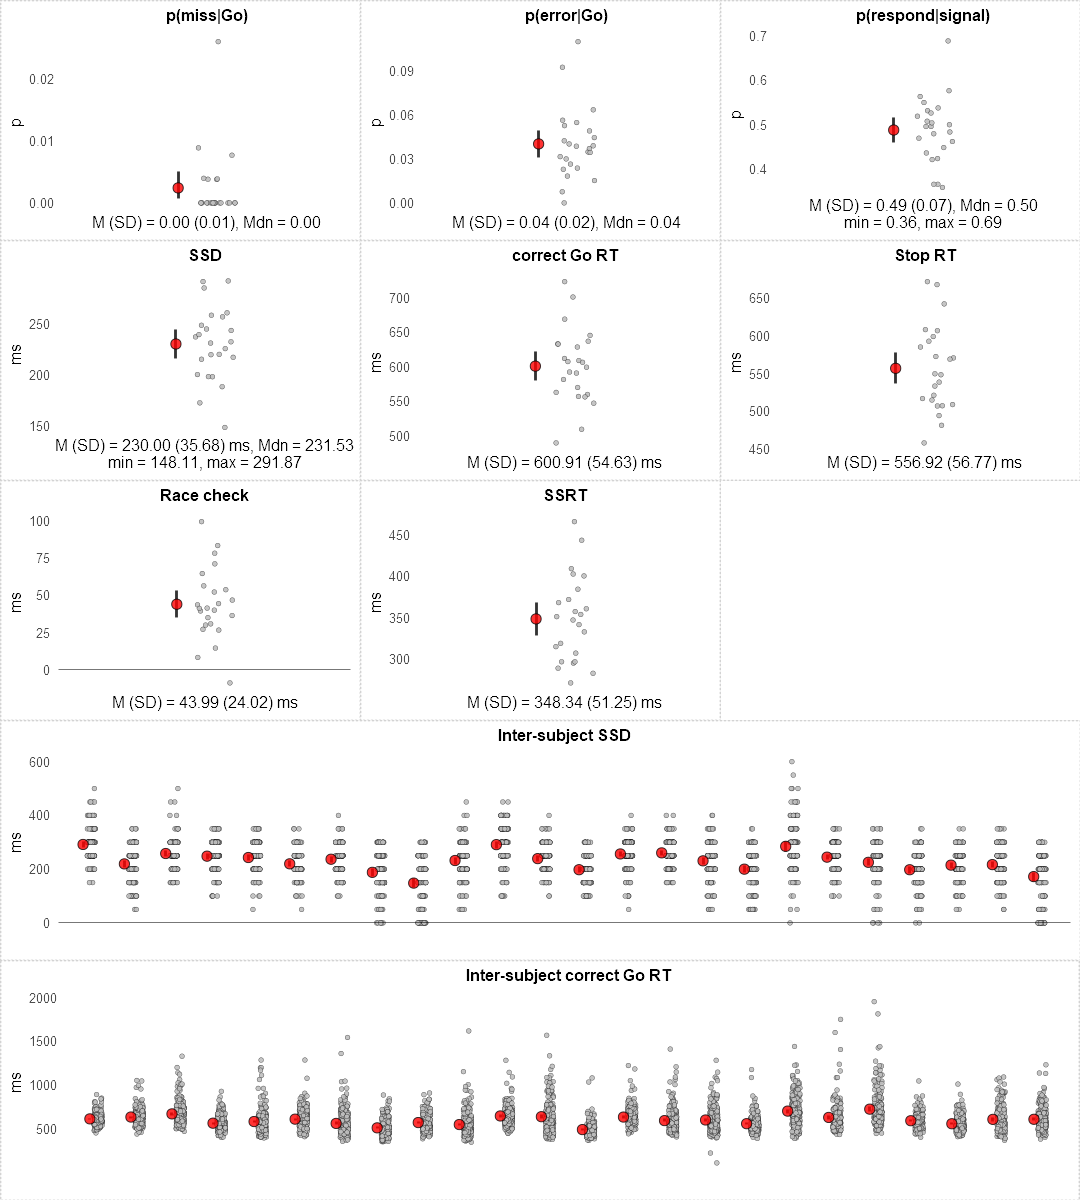

In [20]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 9, repr.plot.height = 10) 
# 1. Probability of Go omissions (no response)
p1 <- plotResults(dataSSTsubj, dataSSTsubj$pmiss, 1, "p(miss|Go)", "p", 
                   sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","pmiss"], dscrSST["std.dev","pmiss"], dscrSST["median","pmiss"]))
# 2. Probability of choice errors on Go trials
p2 <- plotResults(dataSSTsubj, dataSSTsubj$perror, 1, "p(error|Go)", "p",
                   sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","perror"], dscrSST["std.dev","perror"], dscrSST["median","perror"]))
# 3. Probability of responding on a Stop trial
# recommended to refrain from estimating individual SSRTs when p (respond|signal) is lower than 0.25 or higher than 0.75
p3 <- plotResults(dataSSTsubj, dataSSTsubj$presp, 1, "p(respond|signal)", "p",
                    sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","presp"], dscrSST["std.dev","presp"], dscrSST["median","presp"], 
                            dscrSST["min","presp"], dscrSST["max","presp"]))
# 4. Average Stop-Signal Delay
p4 <- plotResults(dataSSTsubj, dataSSTsubj$SSD, 1, "SSD", "ms",
                    sprintf("M (SD) = %.2f (%.2f) ms, Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","SSD"], dscrSST["std.dev","SSD"], dscrSST["median","SSD"], 
                            dscrSST["min","SSD"], dscrSST["max","SSD"]))
# 5. Mean RT on correct Go trials
p5 <- plotResults(dataSSTsubj, dataSSTsubj$goRT, 1, "correct Go RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","goRT"], dscrSST["std.dev","goRT"]))
# 6. RT of unsuccessful Stop trials 
p6 <- plotResults(dataSSTsubj, dataSSTsubj$sRT, 1, "Stop RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","sRT"], dscrSST["std.dev","sRT"]))
# 7. Race Check (with correct Go)
p7 <- plotResults(dataSSTsubj, dataSSTsubj$raceCheck, 1, "Race check", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","raceCheck"], dscrSST["std.dev","raceCheck"])) + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 8. Stop-signal reaction time
# integration method (with replacement of Go omissions) when
p8 <- plotResults(dataSSTsubj, dataSSTsubj$SSRT, 1, "SSRT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","SSRT"], dscrSST["std.dev","SSRT"]))
# 9. Inter-subject variability of SSD
dataSignal <- subset(dataSST, gkind == '1')
p9 <- plotResults(dataSignal, dataSignal$gintVal, dataSignal$sNR, "Inter-subject SSD", "ms", "") + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 10. Inter-subject variability of RT on correct Go trials
#options(repr.plot.width = 8, repr.plot.height = 3)
dataNoSignal <- subset(dataSST, gkind == '0' & gRT != '0')
dataNoSignal$error <- ifelse(dataNoSignal$gtheButton == dataNoSignal$gresp, 0, 1)
dataNoSignalCorr <- subset(dataNoSignal, error == '0')
dataNoSignalCorr.rt <- mean(dataNoSignalCorr$gRT)
p10 <- plotResults(dataNoSignalCorr, dataNoSignalCorr$gRT, dataNoSignalCorr$sNR, "Inter-subject correct Go RT", "ms", "")

## Put all plots in a grid and display
ly1 <- rbind(c(1,2,3),c(4,5,6), c(7,8, NA), c(9,9,9), c(10,10,10))
grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, layout_matrix = ly1)

## Think/No-Think task performance
... 

### Summary data and decriptives

In [7]:
# ==================================================================
# TNT RESULTS
# ==================================================================
# display
# sp - Same probe test
# ip - Independent probe test
# uc - unconditionalised
# c  - conditionalised
print(cbind(dataTNT[, 4:10], round(dataTNT[, 11:ncol(dataTNT)], 0)))

   cgroup testorder    sex age items learned criterion spTuc spNTuc spBuc spSIFuc ipTuc ipNTuc ipBuc ipSIFuc spipTuc
1       A      IPSP Female  19    60      49        82   100     95    95       0    60     45    65      20      80
2       B      IPSP Female  22    60      35        58    80     40    60      20    50     50    55       5      65
3       B      SPIP   Male  25    60      51        85   100     95   100       5    65     45    70      25      82
4       C      IPSP   Male  26    60      51        85    95     90    90       0    55     20    60      40      75
5       C      SPIP Female  22    60      54        90    80     85    90       5    45     55    75      20      62
6       A      SPIP Female  28    60      34        57    80     70    50     -20    70     55    45     -10      75
7       A      IPSP Female  24    60      57        95    95     95    85     -10    40     50    60      10      68
8       B      IPSP Female  25    60      39        65    80    

In [15]:
# Get descriptives
# ----------------------------------------------------------------------
dscrTNT <- stat.desc(dataTNT[, 7:ncol(dataTNT)], basic = TRUE, desc = TRUE, p = 0.95)
print(round(dscrTNT, 0))

             age items learned criterion spTuc spNTuc spBuc spSIFuc ipTuc ipNTuc ipBuc ipSIFuc spipTuc spipNTuc spipBuc
nbr.val       24    24      24        24    24     24    24      24    24     24    24      24      24       24      24
nbr.null       0     0       0         0     0      1     0       6     0      0     0       1       0        0       0
nbr.na         0     0       0         0     0      0     0       0     0      0     0       0       0        0       0
min           19    60      25        42    35      0    35     -20    25     20    30     -15      35       18      32
max           36    60      58        97   100    100   100      60    70     70    75      40      82       78      85
range         17     0      33        55    65    100    65      80    45     50    45      55      48       60      52
sum          592  1440    1028      1713  1885   1670  1810     140  1240   1170  1330     160    1562     1420    1570
median        24    60      44        74

### Result plots

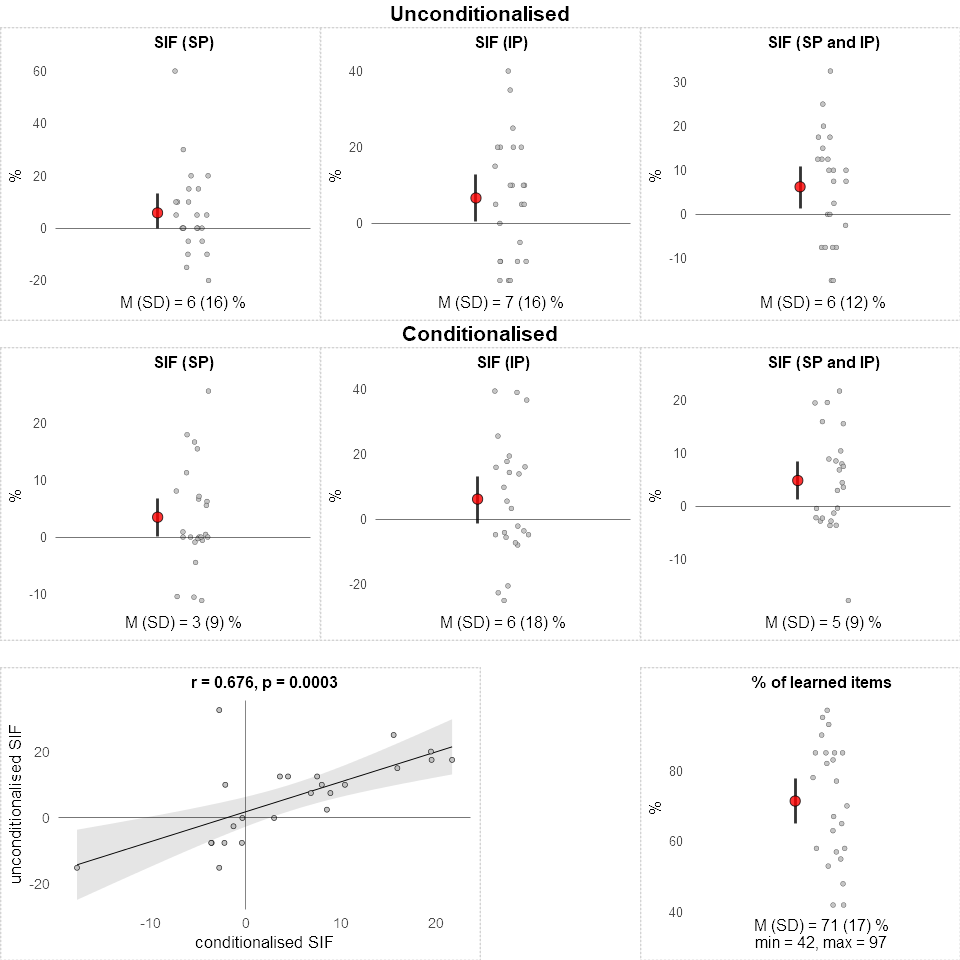

In [9]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 8, repr.plot.height = 8) 
# 1. Unconditionalised SP SIF
p10 <- plotResults(dataTNT, dataTNT$spSIFuc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFuc"], dscrTNT["std.dev","spSIFuc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 2. Unconditionalised IP SIF
p11 <- plotResults(dataTNT, dataTNT$ipSIFuc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFuc"], dscrTNT["std.dev","ipSIFuc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 3. Unconditionalised SPIP SIF SP and IP
p12 <- plotResults(dataTNT, dataTNT$spipSIFuc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFuc"], dscrTNT["std.dev","spipSIFuc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 4. Conditionalised SP SIF
p13 <- plotResults(dataTNT, dataTNT$spSIFc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFc"], dscrTNT["std.dev","spSIFc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 5. Conditionalised IP SIF
p14 <- plotResults(dataTNT, dataTNT$ipSIFc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFc"], dscrTNT["std.dev","ipSIFc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 6. Conditionalised SIF SP and IP
p15 <- plotResults(dataTNT, dataTNT$spipSIFc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFc"], dscrTNT["std.dev","spipSIFc"]))  + 
  geom_hline(aes(yintercept = 0), size = 0.1)
# 7. Relationship between conditionalised and unconditionalised SIFs
corr.SIF <- rcorr(dataTNT$spipSIFuc, dataTNT$spipSIFc)
resTxt  <- sprintf("r = %.3f, p = %.4f", corr.SIF$r[2], corr.SIF$P[2])
p16 <- plotCorrelation(dataTNT, dataTNT$spipSIFc, dataTNT$spipSIFuc, 
                           "conditionalised SIF", "unconditionalised SIF", resTxt, 1, 10) + 
    geom_vline(aes(xintercept = 0), size = 0.1) + geom_hline(aes(yintercept = 0), size = 0.1)
           
# 8. % of learned (included in analysis) items
p17 <- plotResults(dataTNT, dataTNT$criterion, 1, "% of learned items", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%\nmin = %.0f, max = %.0f", 
                           dscrTNT["mean","criterion"], dscrTNT["std.dev","criterion"], 
                           dscrTNT["min","criterion"], dscrTNT["max","criterion"]))

## Put all plots in a grid and display
grid.arrange(arrangeGrob(p10, p11, p12, top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(p13, p14, p15, top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1),
             arrangeGrob(p16, p17, top="", layout_matrix = rbind(c(1,1,1,NA,2,2))))

### SIF effect

In [10]:
# SIF effect (conditionalised, SP and IP)
# ----------------------------------------------------------------------
# http://www.sthda.com/english/wiki/one-sample-t-test-in-r
# Since the sample size is not large enough (less than 30, central limit theorem), we need to check whether 
# the data follow a normal distribution.
# It's possible to use the Shapiro-Wilk normality test and to look at the normality plot.
# 
# Shapiro-Wilk test:
#   Null hypothesis: the data are normally distributed
# Alternative hypothesis: the data are not normally distributed
shapiro.test(dataTNT$spipSIFc)

# SIF data are normally  distributed! Can do t.test. Otherwise would need to to wilcox.test
t.SIFc <- t.test(dataTNT$spipSIFc, mu = 0, alternative = "greater")
t.SIFc
sprintf("SIF effect: t(%d) = %.2f, p = %.3f", t.SIFc$parameter, t.SIFc$statistic, t.SIFc$p.value)


	Shapiro-Wilk normality test

data:  dataTNT$spipSIFc
W = 0.94945, p-value = 0.2636



	One Sample t-test

data:  dataTNT$spipSIFc
t = 2.5519, df = 23, p-value = 0.008912
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 1.592493      Inf
sample estimates:
mean of x 
 4.849436 


[1] "SIF effect: t(23) = 2.55, p = 0.009"

## Outliers

[1] "SSRT outliers:0; SIF outliers: 0"

[1] "Bi-variate outliers: 1"

      SSRT       SIF
9 443.1415 -17.70833


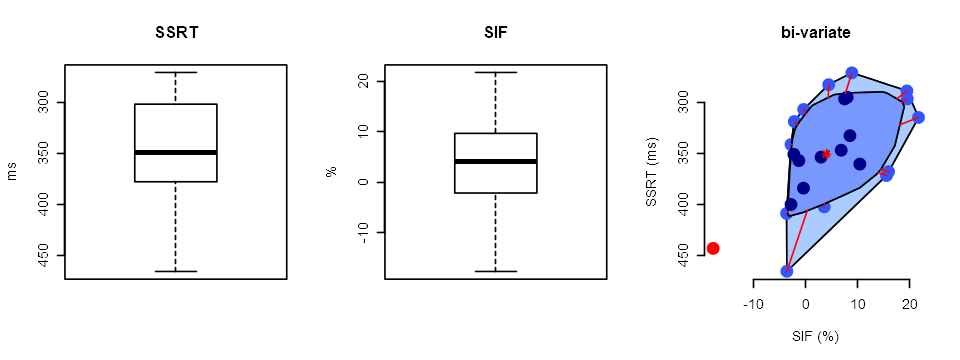

In [11]:
# ==================================================================
# SSRT and SIF OUTLIERS
# ==================================================================
SSRT <- dataSSTsubj$SSRT
SIF  <- dataTNT$spipSIFc

layout(matrix(c(1,2,3), ncol = 3, byrow = TRUE))
options(repr.plot.width = 8, repr.plot.height = 3) # change plot size

# Univariate, boxplot method
# ------------------------------------
bpSSRT <- boxplot(SSRT, main = 'SSRT', ylab = 'ms', ylim = rev(range(SSRT))) 
bpSIF  <- boxplot(SIF, main = 'SIF', ylab = '%')

# Bi-variate, bogplot method
# ------------------------------------
# A bagplot is a bivariate generalization of the  boxplot. A bivariate boxplot. 
bpl  <- compute.bagplot(SSRT, SIF)
oBiv <- which(data.frame(SSRT,SIF) == bpl$pxy.outlier)
bagplot(SIF, SSRT, cex = 2, ylim = rev(range(SSRT)), ylab = 'SSRT (ms)', xlab = 'SIF (%)', main = 'bi-variate')

# Report results
# ------------------------------------
sprintf("SSRT outliers:%d; SIF outliers: %d", length(bpSSRT$out), length(bpSIF$out))
sprintf("Bi-variate outliers: %d", length(oBiv))
print(data.frame(SSRT,SIF)[oBiv, ])

## SSRT and SIF correlation

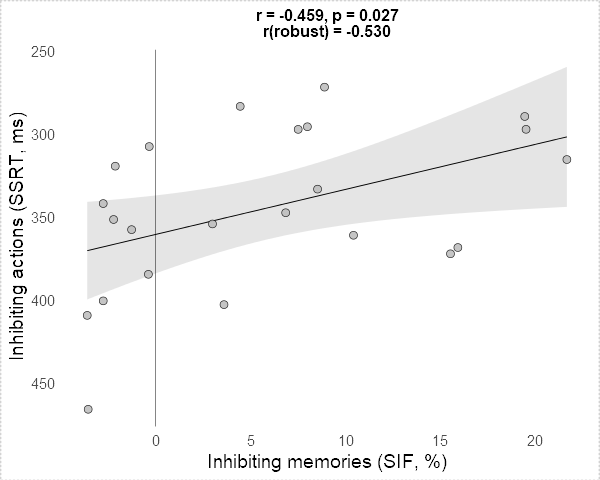

In [12]:
# ==================================================================
# SSRT and SIF CORRELATION
# ==================================================================
sNR <- dataTNT$sNR
res.Inhibition <- data.frame(sNR, SSRT,SIF)

res.Inhibition <- subset(res.Inhibition, sNR != oBiv)

corr.SSRT.SIF <- rcorr(res.Inhibition$SIF, res.Inhibition$SSRT)
# The default "auto" selects from "donostah", "mcd", and "pairwiseQC" with the goal of producing a good estimate 
# in a reasonable amount of time
corrRob.SSRT.SIF <- covRob(cbind(res.Inhibition$SIF, res.Inhibition$SSRT), corr = TRUE, estim = "auto")

resTxt  <- sprintf("r = %.3f, p = %.3f\nr(robust) = %.3f", 
                   corr.SSRT.SIF$r[2], corr.SSRT.SIF$P[2],corrRob.SSRT.SIF$cov[2])
options(repr.plot.width = 5, repr.plot.height = 4) # change plot size
plotCorrelation(res.Inhibition, res.Inhibition$SIF, res.Inhibition$SSRT, 
                "Inhibiting memories (SIF, %)", "Inhibiting actions (SSRT, ms)", resTxt, 1.8, 11) + 
  scale_y_reverse() + geom_vline(aes(xintercept = 0), size = 0.1)

In [13]:
# reset to defult plot size
options(repr.plot.width = 7, repr.plot.height = 7)